In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.utils import shuffle
import shap
import sklearn
import matplotlib.pyplot as plt
import os

df_dpc_ne_test = pd.read_csv('../data/drugminer/pssmdata/dpc_ne_test.csv')
df_dpc_ne_train = pd.read_csv('../data/drugminer/pssmdata/dpc_ne_train.csv')
df_dpc_po_test = pd.read_csv('../data/drugminer/pssmdata/dpc_po_test.csv')
df_dpc_po_train = pd.read_csv('../data/drugminer/pssmdata/dpc_po_train.csv')

df_kp_ne_test = pd.read_csv('../data/drugminer/pssmdata/kp_ne_test.csv')
df_kp_ne_train = pd.read_csv('../data/drugminer/pssmdata/kp_ne_train.csv')
df_kp_po_test = pd.read_csv('../data/drugminer/pssmdata/kp_po_test.csv')
df_kp_po_train = pd.read_csv('../data/drugminer/pssmdata/kp_po_train.csv')

df_sf_ne_test = pd.read_csv('../data/drugminer/pssmdata/sf_ne_test.csv')
df_sf_ne_train = pd.read_csv('../data/drugminer/pssmdata/sf_ne_train.csv')
df_sf_po_test = pd.read_csv('../data/drugminer/pssmdata/sf_po_test.csv')
df_sf_po_train = pd.read_csv('../data/drugminer/pssmdata/sf_po_train.csv')

df_concat_ne_test = pd.concat([df_dpc_ne_test, df_kp_ne_test, df_sf_ne_test], axis=1)
df_concat_ne_test.reset_index(drop=True, inplace=True)

df_concat_ne_train = pd.concat([df_dpc_ne_train, df_kp_ne_train, df_sf_ne_train], axis=1)
df_concat_ne_train.reset_index(drop=True, inplace=True)

# Combine the dataframes for 'po' class and reset the index
df_concat_po_test = pd.concat([df_dpc_po_test, df_kp_po_test, df_sf_po_test], axis=1)
df_concat_po_test.reset_index(drop=True, inplace=True)

df_concat_po_train = pd.concat([df_dpc_po_train, df_kp_po_train, df_sf_po_train], axis=1)
df_concat_po_train.reset_index(drop=True, inplace=True)

In [2]:
X_train = pd.concat([df_concat_ne_train, df_concat_po_train])
y_train = pd.Series([0] * len(df_concat_ne_train) + [1] * len(df_concat_po_train))

X_test = pd.concat([df_concat_ne_test, df_concat_po_test])
y_test = pd.Series([0] * len(df_concat_ne_test) + [1] * len(df_concat_po_test))

X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Shuffle test data
X_test, y_test = shuffle(X_test, y_test, random_state=42)

X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

Specificity: 0.9066147859922179
Accuracy: 0.9037328094302554
Recall: 0.9007936507936508
Precision: 0.9043824701195219
MCC: 0.8074458401832337
F1-score: 0.9025844930417495


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

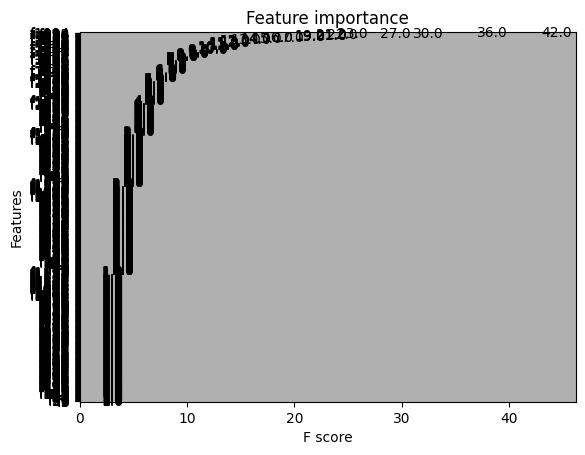

In [4]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, matthews_corrcoef, f1_score, confusion_matrix

# Assuming 'X' is your input data (1200-dimensional) and 'y' is your binary labels
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create XGBoost DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'gamma': 0,
    'seed': 42
}

# Train the XGBoost model
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred = model.predict(dtest)

# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate Specificity (SP)
specificity = TN / (TN + FP)
print(f'Specificity: {specificity}')

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy}')

# Evaluate the recall
recall = recall_score(y_test, y_pred_binary)
print(f'Recall: {recall}')

# Evaluate the precision
precision = precision_score(y_test, y_pred_binary)
print(f'Precision: {precision}')

# Evaluate the Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred_binary)
print(f'MCC: {mcc}')

# Evaluate the F1-score
f1 = f1_score(y_test, y_pred_binary)
print(f'F1-score: {f1}')

# Feature Importance
xgb.plot_importance(model)


In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, matthews_corrcoef, f1_score, confusion_matrix
import numpy as np

# Assuming 'X' is your input data (1200-dimensional) and 'y' is your binary labels
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the SVM model
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Calculate the confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
TN_svm, FP_svm, FN_svm, TP_svm = conf_matrix_svm.ravel()

# Calculate Specificity (SP) for SVM
specificity_svm = TN_svm / (TN_svm + FP_svm)
print(f'Specificity (SVM): {specificity_svm}')

# Evaluate the accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Accuracy (SVM): {accuracy_svm}')

# Evaluate the recall
recall_svm = recall_score(y_test, y_pred_svm)
print(f'Recall (SVM): {recall_svm}')

# Evaluate the precision
precision_svm = precision_score(y_test, y_pred_svm)
print(f'Precision (SVM): {precision_svm}')

# Evaluate the Matthews Correlation Coefficient (MCC)
mcc_svm = matthews_corrcoef(y_test, y_pred_svm)
print(f'MCC (SVM): {mcc_svm}')

# Evaluate the F1-score
f1_svm = f1_score(y_test, y_pred_svm)
print(f'F1-score (SVM): {f1_svm}')


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Specificity (SVM): 0.8326848249027238
Accuracy (SVM): 0.8271119842829077
Recall (SVM): 0.8214285714285714
Precision (SVM): 0.828
MCC (SVM): 0.6541841074710435
F1-score (SVM): 0.8247011952191233


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, matthews_corrcoef, f1_score, confusion_matrix

# Assuming 'X' is your input data (1200-dimensional) and 'y' is your binary labels
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Calculate the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
TN_rf, FP_rf, FN_rf, TP_rf = conf_matrix_rf.ravel()

# Calculate Specificity (SP) for Random Forest
specificity_rf = TN_rf / (TN_rf + FP_rf)
print(f'Specificity (Random Forest): {specificity_rf}')

# Evaluate the accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy (Random Forest): {accuracy_rf}')

# Evaluate the recall
recall_rf = recall_score(y_test, y_pred_rf)
print(f'Recall (Random Forest): {recall_rf}')

# Evaluate the precision
precision_rf = precision_score(y_test, y_pred_rf)
print(f'Precision (Random Forest): {precision_rf}')

# Evaluate the Matthews Correlation Coefficient (MCC)
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)
print(f'MCC (Random Forest): {mcc_rf}')

# Evaluate the F1-score
f1_rf = f1_score(y_test, y_pred_rf)
print(f'F1-score (Random Forest): {f1_rf}')


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Specificity (Random Forest): 0.8599221789883269
Accuracy (Random Forest): 0.8664047151277013
Recall (Random Forest): 0.873015873015873
Precision (Random Forest): 0.859375
MCC (Random Forest): 0.7329154189332786
F1-score (Random Forest): 0.8661417322834646


In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, matthews_corrcoef, f1_score, confusion_matrix

# Assuming 'X' is your input data (1200-dimensional) and 'y' is your binary labels
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Gaussian Naive Bayes classifier
gnb_classifier = GaussianNB()

# Train the Gaussian Naive Bayes model
gnb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gnb = gnb_classifier.predict(X_test)

# Calculate the confusion matrix
conf_matrix_gnb = confusion_matrix(y_test, y_pred_gnb)
TN_gnb, FP_gnb, FN_gnb, TP_gnb = conf_matrix_gnb.ravel()

# Calculate Specificity (SP) for Gaussian Naive Bayes
specificity_gnb = TN_gnb / (TN_gnb + FP_gnb)
print(f'Specificity (Gaussian Naive Bayes): {specificity_gnb}')

# Evaluate the accuracy
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print(f'Accuracy (Gaussian Naive Bayes): {accuracy_gnb}')

# Evaluate the recall
recall_gnb = recall_score(y_test, y_pred_gnb)
print(f'Recall (Gaussian Naive Bayes): {recall_gnb}')

# Evaluate the precision
precision_gnb = precision_score(y_test, y_pred_gnb)
print(f'Precision (Gaussian Naive Bayes): {precision_gnb}')

# Evaluate the Matthews Correlation Coefficient (MCC)
mcc_gnb = matthews_corrcoef(y_test, y_pred_gnb)
print(f'MCC (Gaussian Naive Bayes): {mcc_gnb}')

# Evaluate the F1-score
f1_gnb = f1_score(y_test, y_pred_gnb)
print(f'F1-score (Gaussian Naive Bayes): {f1_gnb}')


Specificity (Gaussian Naive Bayes): 0.8754863813229572
Accuracy (Gaussian Naive Bayes): 0.7347740667976425
Recall (Gaussian Naive Bayes): 0.5912698412698413
Precision (Gaussian Naive Bayes): 0.8232044198895028
MCC (Gaussian Naive Bayes): 0.48750686893321776
F1-score (Gaussian Naive Bayes): 0.6882217090069284


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Accuracy: 0.7111984282907662


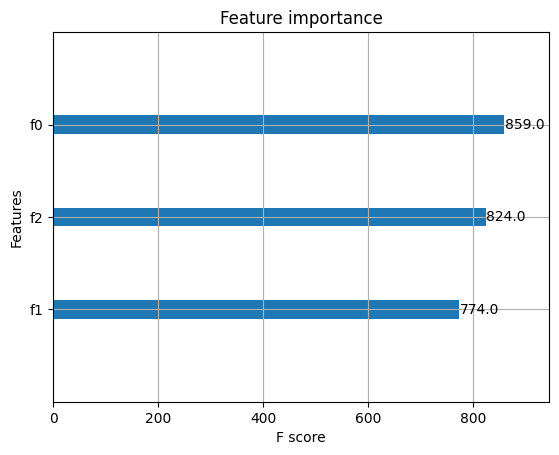

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Combine 20-dimensional vectors into a single feature (assuming every 20 dimensions represent one feature)
combined_features = [np.mean(X[:, i:i+400], axis=1) for i in range(0, 1200, 400)]
X_combined = np.column_stack(combined_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Create XGBoost DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'gamma': 0,
    'seed': 42
}

# Train the XGBoost model
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred = model.predict(dtest)

# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy}')

# Feature Importance
xgb.plot_importance(model)
plt.show()


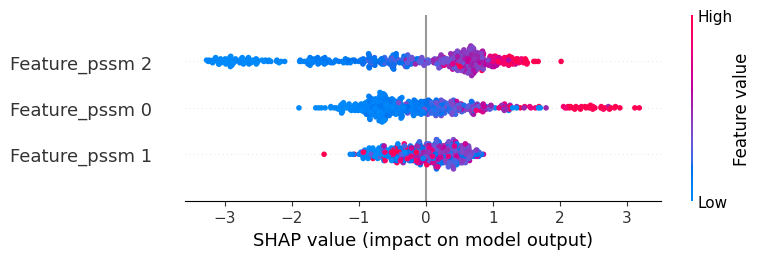

In [ ]:
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.utils import shuffle


# Combine 20-dimensional vectors into a single feature (assuming every 20 dimensions represent one feature)
combined_features = [np.mean(X[:, i:i+400], axis=1) for i in range(0, 1200, 400)]
X_combined = np.column_stack(combined_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Create XGBoost DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'gamma': 0,
    'seed': 42
}

# Train the XGBoost model
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

# SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=[f'Feature_pssm {i}' for i in range(X_test.shape[1])])